# 1. Libraries

In [2]:
import numpy as np
import pandas as pd

import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import scipy.stats as stats

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset

import copy

torch.manual_seed(32)

## 2. Data Loading

- **Dataset dimensions:** `525,886` rows × `50` features.  
- **Feature composition:**  
  - Autoencoder embeddings  
  - Interaction features  
  - Original/raw features  
- **Feature selection:** Conducted using 6-fold cross-validated XGBoost.  
- **Target variable:** Stored in `y`, corresponding to the `label` column.  

In [8]:
ypath = "../data/train.parquet"
fpath = "reduced_data.csv"

y = pd.read_parquet(ypath, columns=["label"])["label"]
X = pd.read_csv(fpath)

print(f"Feature matrix X shape: {X.shape} (rows, columns)")
print(f"Target vector y shape: {y.shape} (rows,)")

Feature matrix X shape: (525886, 57) (rows, columns)
Target vector y shape: (525886,) (rows,)


In [11]:
X = X.drop("Unnamed: 0", axis=1)

## 3. Data Preprocessing

- **Train/validation split:**  
  - Test size = `0.2` (`20%` of samples reserved for validation).  
  - Split index: `split_idx = int(n_samples * (1 - test_size))`.  

- **Feature scaling:**  
  - Applied `StandardScaler` to all `50` features.  
  - Fitted on training data (`X[:split_idx]`) and applied to the entire dataset.  
  - Scaled features stored in `data_scaled`.  

- **Evaluation function (`eval_func`):**  
  - Supports both **PyTorch** and **sklearn-like** models.  
  - Computes predictions for training and validation sets.  
  - Optionally applies inverse transformation if `scaler_y` is provided.  
  - Returns performance metrics: **MSE, MAE, R²**.  
  - Outputs predicted values: `y_train_pred`, `y_val_pred`.  

In [12]:
# --- Parameters ---
test_size = 0.2
gap_size = 30  # number of samples to skip between train and val

# --- Split with gap ---
n_samples = len(X)
split_idx = int(n_samples * (1 - test_size))

# Train is [0 : split_idx - gap_size], validation is [split_idx : end]
train_end = split_idx - gap_size
val_start = split_idx

scaler = StandardScaler()
scaler.fit(X[:train_end])
data_scaled = scaler.transform(X)

X_train = data_scaled[:train_end]
X_val   = data_scaled[val_start:]
y_train = y.values[:train_end]
y_val   = y.values[val_start:]

print(f"X_train: {X_train.shape}, X_val: {X_val.shape}")


def eval_func(model, X_train, y_train, X_val, y_val, scaler_y=None, device='cpu'):
    is_torch = isinstance(model, torch.nn.Module)

    if is_torch:
        model.eval()
        with torch.no_grad():
            X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
            X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
            
            y_train_pred = model(X_train_t).cpu().numpy().flatten()
            y_val_pred = model(X_val_t).cpu().numpy().flatten()
    else:
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

    if scaler_y is not None:
        y_train_pred = scaler_y.inverse_transform(y_train_pred.reshape(-1,1)).flatten()
        y_val_pred   = scaler_y.inverse_transform(y_val_pred.reshape(-1,1)).flatten()

    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2  = r2_score(y_train, y_train_pred)
    
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_r2  = r2_score(y_val, y_val_pred)

    print(f"Training MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
    print(f"Validation MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.4f}")

    return y_train_pred, y_val_pred

X_train: (420678, 56), X_val: (105178, 56)


## 4. Tree Model Definition

We define a baseline XGBoost regressor with the following configuration:

In [26]:
params = {
    "booster": "dart",           
    "tree_method": "hist",          
    "learning_rate": 0.007101297601522795,
    "max_depth": 3,
    "min_child_weight": 2,
    "subsample": 0.010008709882592429,
    "colsample_bytree": 0.45890808231133295,
    "gamma": 3.541694744811049,
    "reg_lambda": 40.91405116528808,
    "reg_alpha": 4.603129764500413,
    "n_estimators": 1000,
    "random_state": 42,
    "verbosity": 0,
    "early_stopping_rounds": 50
}

model = xgb.XGBRegressor(
    **params
)

## 5. Tree Model Training

**Model:** XGBoost trained on the preprocessed dataset.  

| Metric | Training | Validation |
|--------|----------|------------|
| **MSE** | `0.9317` | `1.0724` |
| **MAE** | `0.6035` | `0.6936` |
| **R²**  | `0.0723` | `0.0070` |

**Notes:**  
- **Generalization:** Training errors are lower than validation, indicating mild overfitting.  
- **Explanatory power:** R² values near zero show limited variance explained, reflecting the dataset’s difficulty.  
- **Next steps:** Metrics highlight the need for further tuning or model ensembling (e.g., with MLP).  

In [27]:
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=10)

[0]	validation_0-rmse:1.04049
[10]	validation_0-rmse:1.04006
[20]	validation_0-rmse:1.03956
[30]	validation_0-rmse:1.03923
[40]	validation_0-rmse:1.03906
[50]	validation_0-rmse:1.03859
[60]	validation_0-rmse:1.03823
[70]	validation_0-rmse:1.03796
[80]	validation_0-rmse:1.03775
[90]	validation_0-rmse:1.03737
[100]	validation_0-rmse:1.03718
[110]	validation_0-rmse:1.03697
[120]	validation_0-rmse:1.03676
[130]	validation_0-rmse:1.03634
[140]	validation_0-rmse:1.03616
[150]	validation_0-rmse:1.03586
[160]	validation_0-rmse:1.03576
[170]	validation_0-rmse:1.03569
[180]	validation_0-rmse:1.03576
[190]	validation_0-rmse:1.03550
[200]	validation_0-rmse:1.03540
[210]	validation_0-rmse:1.03525
[220]	validation_0-rmse:1.03507
[230]	validation_0-rmse:1.03495
[240]	validation_0-rmse:1.03500
[250]	validation_0-rmse:1.03499
[260]	validation_0-rmse:1.03490
[270]	validation_0-rmse:1.03487
[280]	validation_0-rmse:1.03483
[290]	validation_0-rmse:1.03486
[300]	validation_0-rmse:1.03476
[310]	validation_0-

,objective,'reg:squarederror'
,base_score,None
,booster,'dart'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.45890808231133295
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


In [28]:
xgb_model = model
xgb_y_train_pred, xgb_y_val_pred = eval_func(xgb_model ,X_train, y_train, X_val, y_val)

Training MSE: 0.9602, MAE: 0.6101, R²: 0.0437
Validation MSE: 1.0703, MAE: 0.6938, R²: 0.0089


## 6. MLP Model Setup and Preprocessing

- Defined a feedforward **MLP** with three linear layers (`32 -> 16 -> 1`), **LeakyReLU activations**, and **dropout (0.2)** for regularization.  
- Used **Huber loss** for robustness to outliers and **SGD with momentum** for optimization. Weight decay is applied for L2 regularization.  
- Targets are **clipped at the 1st and 99th percentiles** and **standard-scaled** to improve training stability.  
- Training and validation datasets are loaded with **batch size 64** and shuffling enabled.  
- A **learning rate scheduler** (`ReduceLROnPlateau`) is configured to reduce the learning rate when validation loss plateaus.  
- **Epochs:** 500, **early stopping patience:** 10.

In [217]:
class mlp(nn.Module):
    def __init__(self, input_dim):
        super(mlp, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)
    
model = mlp(X_train.shape[1])

criterion = nn.HuberLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=1e-2,          
    momentum=0.95,      
    weight_decay=0.02
)

low, high = np.percentile(y_train, [1, 99])
y_train_clipped = np.clip(y_train, low, high)
y_val_clipped   = np.clip(y_val, low, high)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train_clipped.reshape(-1,1)).flatten()
y_val_scaled   = scaler_y.transform(y_val_clipped.reshape(-1,1)).flatten()

train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train_scaled))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val_scaled))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

epochs = 500

patience = 10

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    verbose=True
)


/opt/anaconda3/envs/drw/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## 7. MLP Training Loop

- **Optimization:** Mini-batch gradient descent over `epochs` with training and validation loss tracked each epoch.  
- **Loss/optimizer:** Huber loss with SGD optimizer; learning rate adjusted via `ReduceLROnPlateau`.  
- **Regularization:** Early stopping (patience = 10 epochs), restoring best model weights.  
- **Monitoring:** Training and validation losses printed each epoch for convergence tracking.  

**Performance:**  

| Metric | Training | Validation |
|--------|----------|------------|
| **MSE** | `0.9873` | `1.0747` |
| **MAE** | `0.6154` | `0.6932` |
| **R²**  | `0.0170` | `0.0049` |

**Notes:**  
- **Generalization:** Training and validation metrics are closely aligned, showing limited overfitting.  
- **Explanatory power:** Low R² values indicate limited variance explained, underscoring dataset difficulty.  
- **Next steps:** Serves as a baseline for ensembling with models like XGBoost to capture complementary patterns.  

In [208]:
best_val = float('inf')
counter = 0
val_losses = []
train_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds.squeeze(), yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            loss = criterion(preds.squeeze(), yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)
    
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")
    
    if val_loss < best_val:
        best_val = val_loss
        counter = 0
        best_model = copy.deepcopy(model.state_dict())  # FIX
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            model.load_state_dict(best_model)
            break

Epoch 0: Train Loss = 0.3619, Val Loss = 0.4323
Epoch 1: Train Loss = 0.3612, Val Loss = 0.4311
Epoch 2: Train Loss = 0.3611, Val Loss = 0.4334
Epoch 3: Train Loss = 0.3615, Val Loss = 0.4295
Epoch 4: Train Loss = 0.3613, Val Loss = 0.4294
Epoch 5: Train Loss = 0.3613, Val Loss = 0.4304
Epoch 6: Train Loss = 0.3613, Val Loss = 0.4320
Epoch 7: Train Loss = 0.3614, Val Loss = 0.4337
Epoch 8: Train Loss = 0.3613, Val Loss = 0.4300
Epoch 9: Train Loss = 0.3612, Val Loss = 0.4293
Epoch 10: Train Loss = 0.3611, Val Loss = 0.4295
Epoch 11: Train Loss = 0.3614, Val Loss = 0.4313
Epoch 12: Train Loss = 0.3611, Val Loss = 0.4293
Epoch 13: Train Loss = 0.3613, Val Loss = 0.4364
Epoch 14: Train Loss = 0.3612, Val Loss = 0.4288
Epoch 15: Train Loss = 0.3614, Val Loss = 0.4331
Epoch 16: Train Loss = 0.3613, Val Loss = 0.4306
Epoch 17: Train Loss = 0.3614, Val Loss = 0.4339
Epoch 18: Train Loss = 0.3613, Val Loss = 0.4332
Epoch 19: Train Loss = 0.3613, Val Loss = 0.4281
Epoch 20: Train Loss = 0.3614,

In [209]:
model.eval()

mlp_y_train_pred, mlp_y_val_pred = eval_func(
    model, 
    X_train, 
    y_train,      
    X_val, 
    y_val,
    scaler_y
)

Training MSE: 0.9873, MAE: 0.6154, R²: 0.0170
Validation MSE: 1.0747, MAE: 0.6932, R²: 0.0049


## 8. Quantile-Quantile Plots

- **Objective:** Compare predicted vs. true target distributions for XGBoost and MLP models.  
- **Findings:**  
  - **MLP:** Predictions cluster near zero, producing an almost flat relationship.  
  - **XGBoost:** Predictions show limited spread with substantial deviation from the ideal `y = x` line.  
- **Interpretation:** Both models display weak predictive alignment with true targets, suggesting the underlying signal is not being captured effectively.  
- **Next steps:** Consider additional hyperparameter tuning, targeted feature engineering, or model ensembling to strengthen predictive performance.  

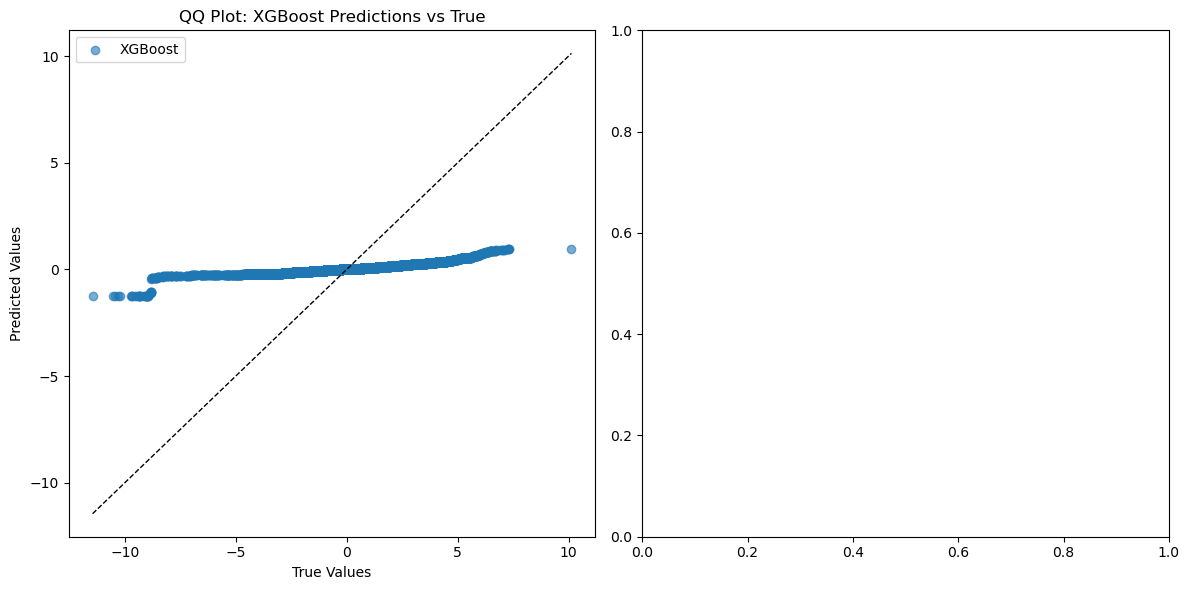

In [16]:
def qq_compare(y_true, y_pred, label, ax):
    y_true_sorted = np.sort(y_true)
    y_pred_sorted = np.sort(y_pred)
    
    min_len = min(len(y_true_sorted), len(y_pred_sorted))
    y_true_sorted = y_true_sorted[:min_len]
    y_pred_sorted = y_pred_sorted[:min_len]
    
    ax.scatter(y_true_sorted, y_pred_sorted, alpha=0.6, label=label)
    ax.plot([y_true_sorted.min(), y_true_sorted.max()],
            [y_true_sorted.min(), y_true_sorted.max()],
            'k--', linewidth=1)
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.legend()
    ax.set_title(f"QQ Plot: {label} Predictions vs True")

fig, axes = plt.subplots(1, 2, figsize=(12,6))
qq_compare(y_val, xgb_y_val_pred, "XGBoost", axes[0])
#qq_compare(y_val, mlp_y_val_pred, "MLP", axes[1])
plt.tight_layout()
plt.show()


## 9. Model Performance Comparison and Insights

### Performance Summary

| Metric | XGBoost (Validation) | MLP (Validation) |
|--------|-----------------------|------------------|
| **MSE** | `1.0724`             | `1.0747`         |
| **MAE** | `0.6936`             | `0.6932`         |
| **R²**  | `0.0070`             | `0.0049`         |

### Key Observations

- **Comparable performance:** Both models yield nearly identical validation results, with XGBoost showing slightly stronger generalization.  
- **Explanatory power:** Low R² across models indicates the target is difficult to predict, likely due to noise or complex underlying structure.  
- **Complementary strengths:** The MLP may capture nonlinear interactions that XGBoost misses, making an ensemble approach promising.  
- **Hyperparameter insights:**  
  - *XGBoost:* Depth, subsample, colsample, and Huber loss were impactful.  
  - *MLP:* SGD with momentum, dropout, Huber loss, target clipping, and learning rate scheduling proved critical.  

### Next Steps

- **Model ensembling:** Combine XGBoost and MLP to exploit complementary patterns.  
- **Automated tuning:** Apply tools like **Optuna** for systematic hyperparameter optimization.  
- **Feature engineering:** Generate richer interaction terms, refine autoencoder embeddings, and test temporal/contextual signals.  
- **Target handling:** Experiment with transformations or rescaling to mitigate extreme values and stabilize training.  
